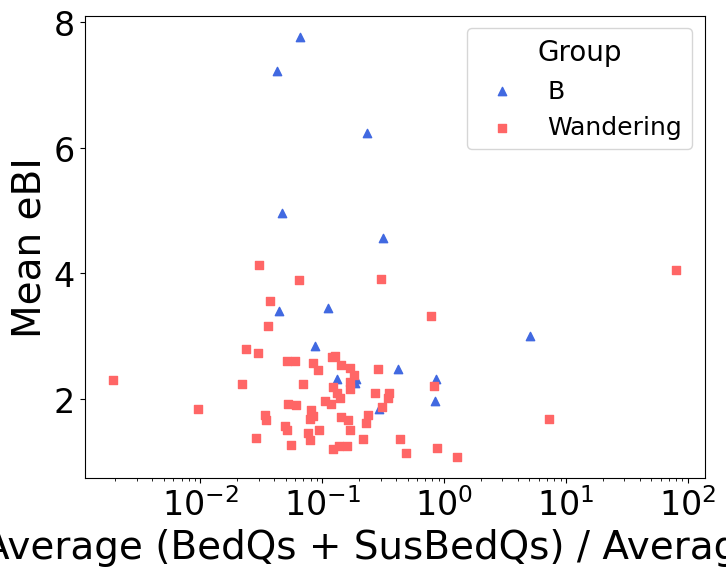

In [24]:
import pandas as pd
import matplotlib.pyplot as plt

# File paths
wbm_csv = r"C:\Users\Feifei\Box\BR_remote_sensing\wbm_data.csv"
ebi_csv = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"

# Read the combined WBM CSV
df_wbm = pd.read_csv(wbm_csv)

# Filter out rivers where BedQs is 0 for all years
df_wbm_filtered = df_wbm.groupby("Name").filter(lambda group: (group["BedQs"] != 0).any())

# Calculate the average Q, average BedQs, and average SusBedQs for each river
grouped = df_wbm_filtered.groupby("Name").agg({
    "Q": "mean",
    "BedQs": "mean",
    "SusBedQs": "mean"
}).reset_index()

# Calculate the ratio as (average BedQs + average SusBedQs) / average Q
grouped["Qs_over_Q"] = (grouped["BedQs"] + grouped["SusBedQs"]) / grouped["Q"]

# Read the eBI combined statistics CSV
df_ebi = pd.read_csv(ebi_csv)

# Merge the two datasets on the river name ("Name" in WBM, "River" in eBI)
merged = pd.merge(grouped, df_ebi, left_on="Name", right_on="River", how="inner")

# (Optional) Remove the unused ratio calculation if not needed:
# merged["BedQs_over_Q"] = merged["BedQs"] / merged["Q"]

# Define markers and colors based on classification
markers = {'Wandering': 's', 'B': '^'}  # 's' for squares, '^' for triangles
colors = {'Wandering': '#FF6666', 'B': '#4169E1'}

# Combine wandering classifications into one group: replace 'HSW' and 'LSW' with 'Wandering'
wandering_types = ['HSW', 'LSW']
merged["Group"] = merged["Classification"].replace(wandering_types, "Wandering")

# Create the scatter plot with a logarithmic x-axis
plt.figure(figsize=(8, 6))
for group, data in merged.groupby("Group"):
    plt.scatter(data["Qs_over_Q"], data["mean_ebi_site"],
                marker=markers.get(group, 'o'),
                color=colors.get(group, 'black'),
                label=group)
                
plt.xscale('log')
#plt.yscale('log')
plt.xlabel("Average (BedQs + SusBedQs) / Average Q")
plt.ylabel("Mean eBI")
plt.legend(title="Group")
plt.show()




In [3]:
from plot_helpers import *
import os
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy import stats 
import pandas as pd
import geopandas as gpd
import cartopy.crs as ccrs
from matplotlib.lines import Line2D
from scipy.stats import linregress
import seaborn as sns
import matplotlib as mpl


In [4]:

# Set global font sizes - for manuscript
mpl.rcParams['font.size'] = 20
mpl.rcParams['axes.labelsize'] = 28
mpl.rcParams['xtick.labelsize'] = 24
mpl.rcParams['ytick.labelsize'] = 24
mpl.rcParams['legend.fontsize'] = 18

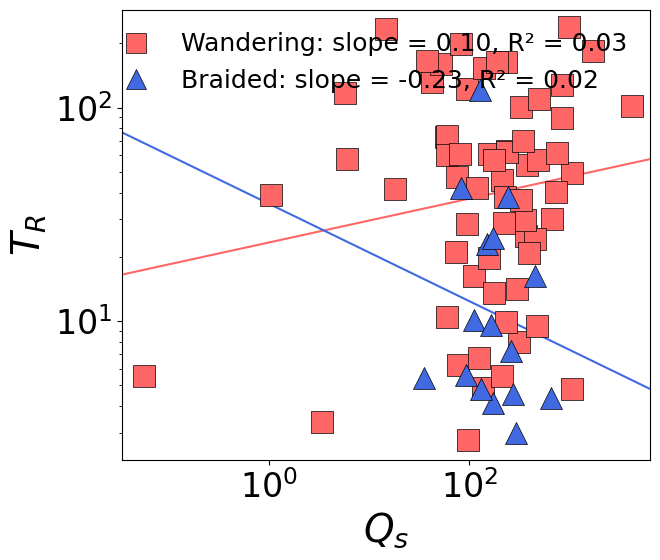

In [9]:
wbm_csv = r"C:\Users\Feifei\Box\BR_remote_sensing\wbm_data.csv"
ebi_csv = r"C:\Users\Feifei\Box\BR_remote_sensing\ebi_combined_statistics.csv"

# Read the WBM CSV
df_wbm = pd.read_csv(wbm_csv)

# Filter out rivers where BedQs is 0 for all years
df_wbm_filtered = df_wbm.groupby("Name").filter(lambda grp: (grp["BedQs"] != 0).any())

# Calculate average Q, BedQs, and SusBedQs for each river
grouped = df_wbm_filtered.groupby("Name").agg({
    "Q": "mean",
    "BedQs": "mean",
    "SusBedQs": "mean"
}).reset_index()

# Define the total Qs (BedQs + SusBedQs)
grouped["Qs"] = grouped["BedQs"] + grouped["SusBedQs"]

# Read the eBI combined CSV
df_ebi = pd.read_csv(ebi_csv)

# Merge the two datasets on "Name" (WBM) vs. "River" (eBI)
merged = pd.merge(grouped, df_ebi, left_on="Name", right_on="River", how="inner")

# Combine 'HSW' and 'LSW' into 'Wandering'
wandering_types = ["HSW", "LSW"]
merged["Group"] = merged["Classification"].replace(wandering_types, "Wandering")

# -------------------------------------------------------------------
# 2) Prepare a figure with the same styling and regression lines
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

# Use log transformations for both axes
MODE = "log-log"

# Dynamically calculate x_range (and y_range) with some padding
x_data_all = merged["Qs"]
y_data_all = merged["T_R"]

# For the log scale, ensure we skip any non-positive values:
pos_mask = (x_data_all > 0) & (y_data_all > 0)
x_data_all = x_data_all[pos_mask]
y_data_all = y_data_all[pos_mask]
merged = merged.loc[pos_mask]

x_min, x_max = x_data_all.min(), x_data_all.max()
y_min, y_max = y_data_all.min(), y_data_all.max()

# Provide some padding
x_range = (x_min * 0.6, x_max * 1.5)
y_range = (y_min * 0.8, y_max * 1.2)

# Define markers and colors
markers = {"Wandering": "s", "B": "^"}
colors = {"Wandering": "#FF6666", "B": "#4169E1"}

# Dictionary to store slope and R² info for the legend
legend_info = {}

# -------------------------------------------------------------------
# 3) Regression & plotting for each group
# -------------------------------------------------------------------
for group in ["Wandering", "B"]:
    subset = merged[merged["Group"] == group]
    if subset.empty:
        continue

    x_data = subset["Qs"]
    y_data = subset["T_R"]

    # Fit regression
    slope, intercept, predict, r2 = fit_regression(x_data, y_data, mode=MODE, return_r2=True)

    # Generate a smooth set of x values across x_range
    x_line = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 300)
    # Predict y
    y_line = predict(x_line)

    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)

    # For the legend label, rename "B" -> "Braided"
    group_label = "Braided" if group == "B" else group
    legend_info[group] = f"{group_label}: slope = {slope:.2f}, R² = {r2:.2f}"


# -------------------------------------------------------------------
# 4) Scatter plot (data points)
# -------------------------------------------------------------------
for group in ["Wandering", "B"]:
    subset = merged[merged["Group"] == group]
    if subset.empty:
        continue

    x_data = subset["Qs"]
    y_data = subset["T_R"]

    # Also rename "B" -> "Braided" for the scatter legend
    group_label = "Braided" if group == "B" else group

    ax.scatter(
        x_data, 
        y_data,
        label=group_label,
        marker=markers.get(group, 'o'),
        c=colors.get(group, 'black'),
        edgecolors="black",
        s=250,
        alpha=1,
        zorder=2,
        linewidths=0.5
    )

# Set both axes to log scale
ax.set_xscale("log")
ax.set_yscale("log")

# Adjust limits
ax.set_xlim(*x_range)
ax.set_ylim(*y_range)

# Label axes
ax.set_xlabel(r'${Q_{s}}$')  # using LaTeX for "Qs"
ax.set_ylabel(r'${T_{R}}$')

# Build a custom legend with slope and R²
legend_elements = []
for group in ["Wandering", "B"]:
    if group in legend_info:
        legend_elements.append(
            Line2D(
                [0],
                [0],
                marker=markers[group],
                color="w",
                label=legend_info[group],  # already includes group label
                markerfacecolor=colors[group],
                markersize=15,
                markeredgecolor="black",
                markeredgewidth=0.5,
                linestyle="None",
            )
        )

ax.legend(handles=legend_elements, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()



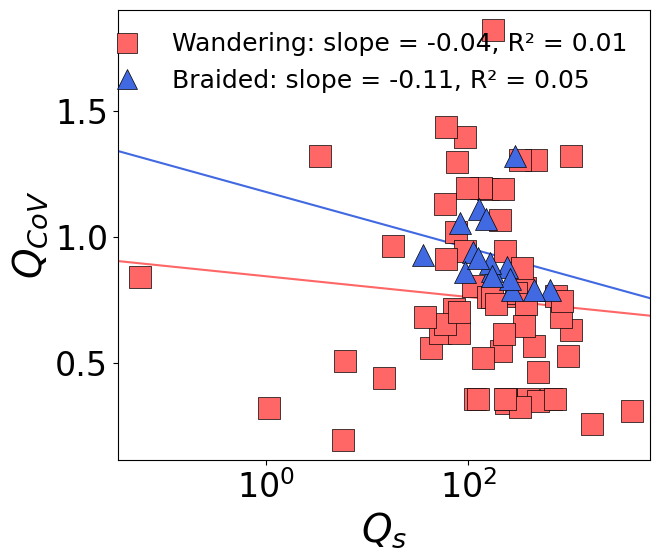

In [14]:
# -------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(7, 6))

# Dynamically calculate x_range (and y_range) with some padding
x_data_all = merged["Qs"]
y_data_all = merged["T_R"]

# For the log scale, ensure we skip any non-positive values:
pos_mask = (x_data_all > 0) & (y_data_all > 0)
x_data_all = x_data_all[pos_mask]
y_data_all = y_data_all[pos_mask]
merged = merged.loc[pos_mask]

x_min, x_max = x_data_all.min(), x_data_all.max()
y_min, y_max = y_data_all.min(), y_data_all.max()

# Provide some padding
x_range = (x_min * 0.6, x_max * 1.5)
y_range = (y_min * 0.8, y_max * 1.2)

# Define markers and colors
markers = {"Wandering": "s", "B": "^"}
colors = {"Wandering": "#FF6666", "B": "#4169E1"}

# Dictionary to store slope and R² info for the legend
legend_info = {}

# -------------------------------------------------------------------
# 3) Regression & plotting for each group
# -------------------------------------------------------------------
for group in ["Wandering", "B"]:
    subset = merged[merged["Group"] == group]
    if subset.empty:
        continue

    x_data = subset["Qs"]
    y_data = subset["cov_discharge_site"]

    # Fit regression
    slope, intercept, predict = fit_regression(x_data, y_data, mode="log-x")

    # Generate a smooth set of x values across x_range
    x_line = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 300)
    # Predict y
    y_line = predict(x_line)

    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)
    # Compute R²
    y_pred = predict(x_data)
    ss_res = np.sum((y_data - y_pred) ** 2)
    ss_tot = np.sum((y_data - y_data.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 0

    # For the legend label, rename "B" -> "Braided"
    group_label = "Braided" if group == "B" else group
    legend_info[group] = f"{group_label}: slope = {slope:.2f}, R² = {r2:.2f}"


# -------------------------------------------------------------------
# 4) Scatter plot (data points)
# -------------------------------------------------------------------
for group in ["Wandering", "B"]:
    subset = merged[merged["Group"] == group]
    if subset.empty:
        continue

    x_data = subset["Qs"]
    y_data = subset["cov_discharge_site"]

    # Also rename "B" -> "Braided" for the scatter legend
    group_label = "Braided" if group == "B" else group

    ax.scatter(
        x_data, 
        y_data,
        label=group_label,
        marker=markers.get(group, 'o'),
        c=colors.get(group, 'black'),
        edgecolors="black",
        s=250,
        alpha=1,
        zorder=2,
        linewidths=0.5
    )

# Set both axes to log scale
ax.set_xscale("log")
#ax.set_yscale("log")

# Adjust limits
ax.set_xlim(*x_range)
#ax.set_ylim(*y_range)

# Label axes
ax.set_xlabel(r'${Q_{s}}$')  # using LaTeX for "Qs"
ax.set_ylabel(r'${Q_{CoV}}$')

# Build a custom legend with slope and R²
legend_elements = []
for group in ["Wandering", "B"]:
    if group in legend_info:
        legend_elements.append(
            Line2D(
                [0],
                [0],
                marker=markers[group],
                color="w",
                label=legend_info[group],  # already includes group label
                markerfacecolor=colors[group],
                markersize=15,
                markeredgecolor="black",
                markeredgewidth=0.5,
                linestyle="None",
            )
        )

ax.legend(handles=legend_elements, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()


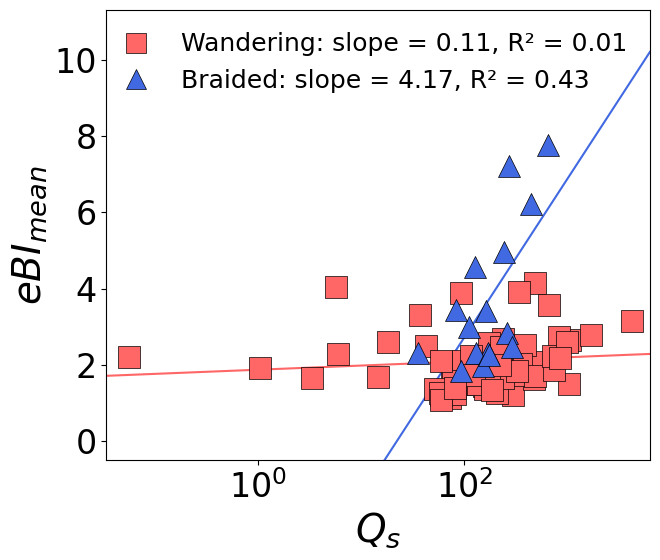

In [19]:
fig, ax = plt.subplots(figsize=(7, 6))

# Dynamically calculate x_range (and y_range) with some padding
x_data_all = merged["Qs"]
y_data_all = merged["T_R"]

# For the log scale, ensure we skip any non-positive values:
pos_mask = (x_data_all > 0) & (y_data_all > 0)
x_data_all = x_data_all[pos_mask]
y_data_all = y_data_all[pos_mask]
merged = merged.loc[pos_mask]

x_min, x_max = x_data_all.min(), x_data_all.max()
y_min, y_max = y_data_all.min(), y_data_all.max()

# Provide some padding
x_range = (x_min * 0.6, x_max * 1.5)
y_range = (y_min * 0.8, y_max * 1.2)

# Define markers and colors
markers = {"Wandering": "s", "B": "^"}
colors = {"Wandering": "#FF6666", "B": "#4169E1"}

# Dictionary to store slope and R² info for the legend
legend_info = {}

# -------------------------------------------------------------------
# 3) Regression & plotting for each group
# -------------------------------------------------------------------
for group in ["Wandering", "B"]:
    subset = merged[merged["Group"] == group]
    if subset.empty:
        continue

    x_data = subset["Qs"]
    y_data = subset["mean_ebi_site"]

    # Fit regression
    slope, intercept, predict= fit_regression(x_data, y_data, mode="log-x")

    y_pred = predict(x_data)
    ss_res = np.sum((y_data - y_pred) ** 2)
    ss_tot = np.sum((y_data - y_data.mean()) ** 2)
    r2 = 1 - ss_res / ss_tot if ss_tot != 0 else 0

    # Generate a smooth set of x values across x_range
    x_line = np.logspace(np.log10(x_range[0]), np.log10(x_range[1]), 300)
    # Predict y
    y_line = predict(x_line)

    # Plot the regression line
    ax.plot(x_line, y_line, color=colors[group], lw=1.5)

    # For the legend label, rename "B" -> "Braided"
    group_label = "Braided" if group == "B" else group
    legend_info[group] = f"{group_label}: slope = {slope:.2f}, R² = {r2:.2f}"


# -------------------------------------------------------------------
# 4) Scatter plot (data points)
# -------------------------------------------------------------------
for group in ["Wandering", "B"]:
    subset = merged[merged["Group"] == group]
    if subset.empty:
        continue

    x_data = subset["Qs"]
    y_data = subset["mean_ebi_site"]

    # Also rename "B" -> "Braided" for the scatter legend
    group_label = "Braided" if group == "B" else group

    ax.scatter(
        x_data, 
        y_data,
        label=group_label,
        marker=markers.get(group, 'o'),
        c=colors.get(group, 'black'),
        edgecolors="black",
        s=250,
        alpha=1,
        zorder=2,
        linewidths=0.5
    )

# Set both axes to log scale
ax.set_xscale("log")
#ax.set_yscale("log")

# Adjust limits
ax.set_xlim(*x_range)
ax.set_ylim(bottom=-0.5)

# Label axes
ax.set_xlabel(r'${Q_{s}}$')  # using LaTeX for "Qs"
ax.set_ylabel(r'${eBI_{mean}}$')

# Build a custom legend with slope and R²
legend_elements = []
for group in ["Wandering", "B"]:
    if group in legend_info:
        legend_elements.append(
            Line2D(
                [0],
                [0],
                marker=markers[group],
                color="w",
                label=legend_info[group],  # already includes group label
                markerfacecolor=colors[group],
                markersize=15,
                markeredgecolor="black",
                markeredgewidth=0.5,
                linestyle="None",
            )
        )

ax.legend(handles=legend_elements, loc="upper right", frameon=False)

plt.tight_layout()
plt.show()
